In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import CCA


from tqdm import tqdm, trange

import warnings
from sklearn.exceptions import ConvergenceWarning

from PyEMD import EMD


In [12]:
torch.cuda.empty_cache()




In [37]:
from scipy.signal import welch
import numpy as np

def compute_bandpower(data, fs, band):
    freqs, psd = welch(data, fs=fs, nperseg=fs//2)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[idx_band], freqs[idx_band])

def compute_rms(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_hjorth_params(x):
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(x)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) if var_d1 != 0 else 0

    return mobility, complexity

In [38]:
def normalize_signal(signal):
    max_abs = np.max(np.abs(signal))
    return signal / max_abs if max_abs != 0 else signal

class EEGWindowDataset(Dataset):
    def __init__(self, combined_data_path, training_data_path, sampling_rate=250, window_sec=2):
        self.combined_data = pd.read_csv(combined_data_path).values.astype(np.float32)
        self.training_data = pd.read_csv(training_data_path).values.astype(np.int64)

        self.window_size = int(window_sec * sampling_rate)
        self.half_window = self.window_size // 2

        self.total_rows = self.combined_data.shape[0]
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        class_label, center_idx = self.training_data[idx]

        # Define full 2-second window
        start_idx = center_idx - self.half_window
        end_idx = center_idx + self.half_window

        # Edge padding if needed
        if start_idx < 0 or end_idx > self.total_rows:
            window = np.zeros((self.window_size, 4), dtype=np.float32)
            actual_start = max(0, start_idx)
            actual_end = min(self.total_rows, end_idx)
            window_offset_start = max(0, -start_idx)
            window[window_offset_start:window_offset_start + (actual_end - actual_start)] = \
                self.combined_data[actual_start:actual_end, :4]
        else:
            window = self.combined_data[start_idx:end_idx, :4]

        # Split window into 4 segments (0.5s each @ 250 Hz = 125 samples)
        segment_size = self.window_size // 4  # 0.5 seconds = 125 samples
        features_per_segment = []

        for i in range(4):  # 4 segments
            segment = window[i * segment_size: (i + 1) * segment_size, :]
            segment_features = []

            for ch in range(4):  # 4 channels
                signal = segment[:, ch]

                alpha = compute_bandpower(signal, fs=self.sampling_rate, band=(8, 13))
                beta = compute_bandpower(signal, fs=self.sampling_rate, band=(13, 30))
                rms = compute_rms(signal)
                mobility, complexity = compute_hjorth_params(signal)
                skewness = skew(signal)

                segment_features.extend([alpha, beta, mobility, rms, complexity])

            features_per_segment.append(segment_features)  # shape: (20,)

        feature_tensor = torch.tensor(features_per_segment, dtype=torch.float32)  # shape: (4, 20)
        return feature_tensor, class_label

# Model

In [34]:
# Define the MLP model
class EEGClassifier(nn.Module):
    def __init__(self):
        super(EEGClassifier, self).__init__()
        self.fc1 = nn.Linear(20, 32)       # Input: 20 features → Hidden: 32 neurons
        self.fc2 = nn.Linear(32, 11)       # Hidden: 32 neurons → Output: 11 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))            # Activation
        x = F.softmax(self.fc2(x), dim=1)  # Softmax for classification
        return x

# Instantiate the model
model = EEGClassifier()

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [39]:
class EEG_LSTMClassifier(nn.Module):
    def __init__(self, input_size=20, hidden_size=32, num_layers=2, num_classes=11, dropout=0.3):
        super(EEG_LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, time_steps, features)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, time_steps, hidden_size)
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]  # shape: (batch_size, hidden_size)

        out = self.fc(last_output)  # shape: (batch_size, num_classes)
        return out

In [40]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device='cpu'):
    model.to(device)
    count = 0
    epoch_bar = trange(num_epochs, desc="Training Epochs", unit="epoch")
    
    for epoch in epoch_bar:
        # -------- Training Phase --------
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        
        #print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")
        # -------- Validation Phase --------
        if count == num_epochs - 1:
            model.eval()
            y_true, y_pred = [], []
    
            with torch.no_grad():
                for val_X, val_y in val_loader:
                    val_X, val_y = val_X.to(device), val_y.to(device)
                    outputs = model(val_X)
                    preds = torch.argmax(outputs, dim=1)
    
                    y_true.extend(val_y.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
    
            # ----- Confusion Matrix -----
            cm = confusion_matrix(y_true, y_pred)
            #print("Confusion Matrix:")
           # print(cm)
            
            #print("\nClassification Report:")
            #print(classification_report(y_true, y_pred, digits=3))

            val_accuracy = accuracy_score(y_true, y_pred)
            
        count += 1
    return val_accuracy, avg_loss, cm

## Window Size Optimization

Using device: cuda
Training for Window Size: 2


Training Epochs: 100%|██████████████████████████████████████████████████████████████| 30/30 [05:44<00:00, 11.48s/epoch]


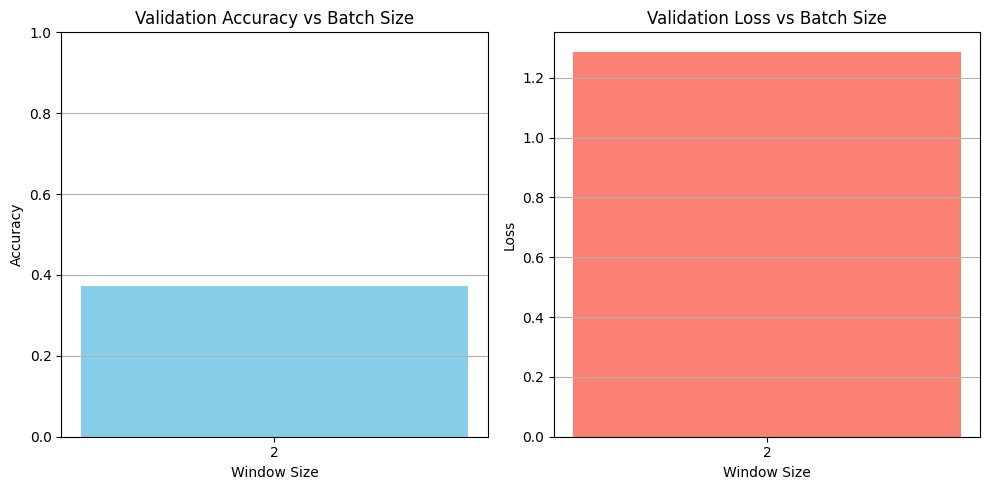

In [41]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

window_sizes = [2]
cm_array = []
accuracies = []
losses = []

for window_size in window_sizes:
    print("Training for Window Size:", window_size)

    model = EEG_LSTMClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    training_dataset = EEGWindowDataset("TrainingData/combined_data.csv", "TrainingData/training_data.csv", sampling_rate=250, window_sec=window_size)
    testing_dataset = EEGWindowDataset("TrainingData/combined_data.csv", "TrainingData/testing_data.csv", sampling_rate=250, window_sec=window_size)

    train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(testing_dataset, batch_size=16, shuffle=False)

    acc, loss, cm = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device=device)
    cm_array.append(cm)
    accuracies.append(acc)
    losses.append(loss)

plt.figure(figsize=(10, 5))

# Accuracy bar plot
plt.subplot(1, 2, 1)
plt.bar([str(bs) for bs in window_sizes], accuracies, color='skyblue')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')

# Loss bar plot
plt.subplot(1, 2, 2)
plt.bar([str(bs) for bs in window_sizes], losses, color='salmon')
plt.title("Validation Loss vs Batch Size")
plt.xlabel("Window Size")
plt.ylabel("Loss")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [43]:
torch.save(model.state_dict(), "model.pth")

In [42]:
for i in range(len(cm_array)):
    print(cm_array[i])
    print("Accuracy: ", accuracies[i])
    print("Loss: ", losses[i])
    

[[ 4  4  0  0  0  0  0  1  0  1  1]
 [ 0 16  0  0  0  0  0  0  0  1  2]
 [ 0 14  2  1  0  0  0  0  0  2  4]
 [ 0  0  0  2 10  3  4  0  0  0  0]
 [ 0  0  0  1  4  1  6  0  0  0  0]
 [ 0  0  0  1  1 11  8  0  0  0  0]
 [ 0  0  0  1  3  8  8  0  0  0  0]
 [ 1  0  0  0  3  1  4  1  7  0  0]
 [ 1  0  0  0  4  1  6  0  9  0  0]
 [ 0  0  0  0  1  0  0  0  0  3 15]
 [ 0  1  0  0  0  0  0  0  0  0 13]]
Accuracy:  0.37244897959183676
Loss:  1.2878583791304608


In [99]:
for i in range(len(cm_array)):
    print(cm_array[i])
    print("Accuracy: ", accuracies[i])
    print("Loss: ", losses[i])

[[ 4  4  0  0  0  0  0  0  2  0  1]
 [ 1 15  0  0  0  0  0  0  0  2  1]
 [ 0 16  0  0  0  0  0  0  1  4  2]
 [ 0 14  0  0  0  0  0  0  5  0  0]
 [ 0 10  1  0  0  0  0  0  1  0  0]
 [ 0 18  0  0  0  0  0  0  3  0  0]
 [ 0 13  0  0  0  0  0  0  7  0  0]
 [ 0  8  1  0  0  0  0  0  8  0  0]
 [ 0  6  0  0  0  0  0  0 15  0  0]
 [ 1  2  0  0  0  0  0  0  0 12  4]
 [ 0  4  0  0  0  0  0  0  0  5  5]]
Accuracy:  0.2602040816326531
Loss:  2.2583115976683947


## Batch Size Optimization

Training for Batch Size: 8


Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:53<00:01,  1.81s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 4  3  1  0  0  0  0  0  1  0  2]
 [ 1 13  2  0  0  0  0  0  0  2  1]
 [ 0 13  4  0  0  0  0  0  0  4  2]
 [ 1 12  3  0  0  0  0  0  3  0  0]
 [ 0  8  4  0  0  0  0  0  0  0  0]
 [ 0 12  3  0  0  0  0  0  6  0  0]
 [ 1  9  4  0  0  0  0  0  6  0  0]
 [ 0  5  2  0  0  0  0  0 10  0  0]
 [ 0  4  2  0  0  0  0  0 15  0  0]
 [ 1  0  0  0  0  0  0  0  0 14  4]
 [ 0  1  0  0  0  0  0  0  0  6  7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.500     0.364     0.421        11
           1      0.163     0.684     0.263        19
           2      0.160     0.174     0.167        23
           3      0.000     0.000     0.000        19
           4      0.000     0.000     0.000        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.000     0.000     0.000        17
           8      0.366     0.714     0.484        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:49<00:01,  1.69s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  2  4  0  0  0  0  3  0  0  2]
 [ 0  6 10  0  0  0  0  1  0  1  1]
 [ 0  6 12  0  0  0  0  0  0  3  2]
 [ 0  2  0  0  2 15  0  0  0  0  0]
 [ 0  1  0  0  1 10  0  0  0  0  0]
 [ 0  0  0  0  3 18  0  0  0  0  0]
 [ 0  0  1  0  1 18  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  8  0  0  0]
 [ 0  1  1  0  2  9  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  4]
 [ 0  0  0  0  0  1  0  0  0  6  7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.333     0.316     0.324        19
           2      0.429     0.522     0.471        23
           3      0.000     0.000     0.000        19
           4      0.111     0.083     0.095        12
           5      0.225     0.857     0.356        21
           6      0.000     0.000     0.000        20
           7      0.400     0.471     0.432        17
           8      0.000     0.000     0.000        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:47<00:01,  1.64s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  0  4  2  0  0  0  3  0  1  1]
 [ 0  6 10  0  0  0  0  1  0  2  0]
 [ 0  5 11  1  0  0  0  1  0  3  2]
 [ 0  1  0 17  0  0  0  1  0  0  0]
 [ 0  2  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  7  0  0  0]
 [ 0  0  0 12  0  0  0  8  0  0  0]
 [ 0  0  0  5  0  0  0 12  0  0  0]
 [ 0  0  0  6  0  0  0 15  0  0  0]
 [ 0  0  1  0  0  0  0  1  0 13  4]
 [ 0  0  0  1  0  0  0  0  0  7  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.429     0.316     0.364        19
           2      0.423     0.478     0.449        23
           3      0.250     0.895     0.391        19
           4      0.000     0.000     0.000        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.245     0.706     0.364        17
           8      0.000     0.000     0.000        21
           9      0.

Training Epochs:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [00:49<00:01,  1.92s/epoch]C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shawn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

Confusion Matrix:
[[ 0  0  4  0  0  0  0  4  0  0  3]
 [ 0  0 16  0  0  0  0  1  0  2  0]
 [ 0  0 17  0  2  0  0  0  0  2  2]
 [ 0  0  1  0 16  0  0  2  0  0  0]
 [ 0  0  1  0  9  0  0  2  0  0  0]
 [ 0  0  0  0 15  0  0  6  0  0  0]
 [ 0  0  0  0 14  0  0  5  0  0  1]
 [ 0  0  0  0  5  0  0 12  0  0  0]
 [ 0  0  0  0  6  0  0 15  0  0  0]
 [ 0  0  3  0  0  0  0  0  0 11  5]
 [ 0  0  1  0  1  0  0  0  0  6  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.000     0.000     0.000        19
           2      0.395     0.739     0.515        23
           3      0.000     0.000     0.000        19
           4      0.132     0.750     0.225        12
           5      0.000     0.000     0.000        21
           6      0.000     0.000     0.000        20
           7      0.255     0.706     0.375        17
           8      0.000     0.000     0.000        21
           9      0.

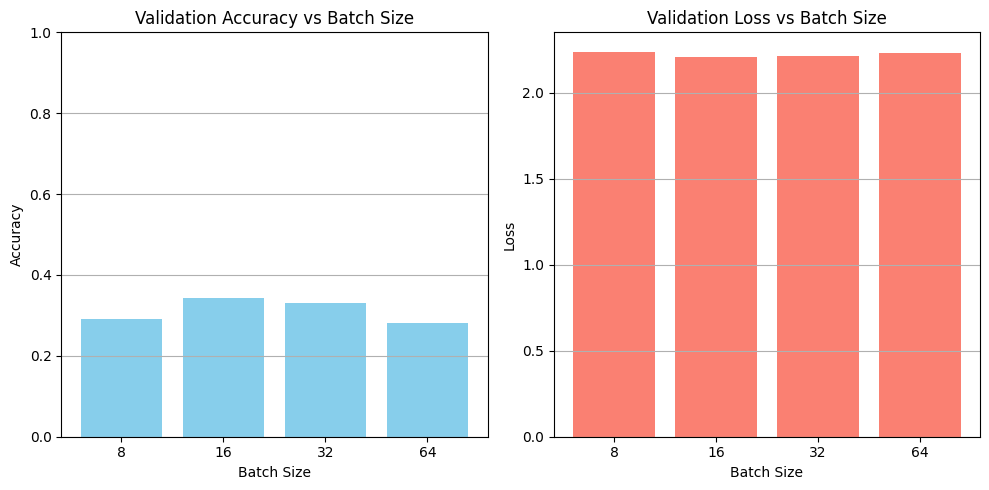

In [8]:
batch_sizes = [8, 16,32,64]
accuracies = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

for batch_size in batch_sizes:
    print("Training for Batch Size:", batch_size)

    model = EEGClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

    acc, loss, cm = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, device=device)
    accuracies.append(acc)
    losses.append(loss)

plt.figure(figsize=(10, 5))

# Accuracy bar plot
plt.subplot(1, 2, 1)
plt.bar([str(bs) for bs in batch_sizes], accuracies, color='skyblue')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')

# Loss bar plot
plt.subplot(1, 2, 2)
plt.bar([str(bs) for bs in batch_sizes], losses, color='salmon')
plt.title("Validation Loss vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()